## 공공데이터를 이용한 카페 상권분석(2022 Ver.)


**들어가며**

- 공공데이터를 통해 대한민국을 이해해봅시다(?).
- 공공데이터포털(data.go.kr)에 다양한 데이터가 공개되어 있습니다.
- 그 중에 카페(라는 업종분류)들에 대해서 현황을 조사하려고 합니다.

**명세사항**
1. 전국 카페 데이터를 모두 수집해야합니다.
2. 지역별 or 브랜드별 점포 현황을 확인합니다.
3. 분석 결과를 시각화합니다. 

## 0. Data Description

- 소상공인 상권 데이터를 국내에 있는 모든 소상공인으로 등록된 점포들에 대한 정보를 제공합니다.

[데이터] https://www.data.go.kr/data/15083033/fileData.do

In [1]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

# 커널을 구성하다보면 에러는 아니지만, 빨간색 네모 박스 warning이 뜨는 경우가 많다. 
# 그런 보기 싫은 부분들을 제거해주겠다.
import warnings
warnings.filterwarnings('ignore')

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
# %matplotlib inline

# os 패키지를 통해 현재 디렉토리 위치를 변경하고, read_csv를 더 편리하게 할 수 있음
import os
# os.getcwd() # 현재 디렉토리 파악
# os.chdir(r"______") # 불러오고 싶은 파일이 위치한 주소를 ___에 입력
from collections import Counter
from glob import glob


# 다른 노트북 작성할 때도 이 셀만 떼서 사용 가능하다.
import platform                

# 웬만하면 해주는 것이 좋다.
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin': #맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':#윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

# tqdm
from tqdm.notebook import tqdm

### 1. 데이터 불러오기

In [2]:
# 다운로드 받은 데이터중 일부를 열어봅니다.
base_path = 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231/'
df_seoul = pd.read_csv(base_path + '소상공인시장진흥공단_상가(상권)정보_서울_202112.csv')
df_seoul.shape

(315294, 39)

In [3]:
df_seoul.head(3)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,23324279,제중건강원,NaN,D,소매,D10,건강/미용식품,D10A07,건강원,G47216,...,1156010600100410002034626,NaN,서울특별시 영등포구 영중로14길 11-17,150035,7250.0,NaN,1,NaN,126.907168,37.520613
1,24525909,민속악기사,NaN,D,소매,D04,취미/오락관련소매,D04A09,악기판매,G47593,...,1120012200101420011000227,NaN,서울특별시 성동구 용답5길 2,133849,4803.0,NaN,NaN,NaN,127.049018,37.566857
2,24715368,태평양진주,NaN,D,소매,D26,시계/귀금속소매,D26A01,시계/귀금속,G47830,...,1111015200100440000000001,금사랑투빌딩,서울특별시 종로구 서순라길 17-10,110390,3138.0,NaN,NaN,NaN,126.993530,37.571848


In [4]:
df_seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315294 entries, 0 to 315293
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     315294 non-null  int64  
 1   상호명        315293 non-null  object 
 2   지점명        55561 non-null   object 
 3   상권업종대분류코드  315294 non-null  object 
 4   상권업종대분류명   315294 non-null  object 
 5   상권업종중분류코드  315294 non-null  object 
 6   상권업종중분류명   315294 non-null  object 
 7   상권업종소분류코드  315294 non-null  object 
 8   상권업종소분류명   315294 non-null  object 
 9   표준산업분류코드   296187 non-null  object 
 10  표준산업분류명    296187 non-null  object 
 11  시도코드       315294 non-null  int64  
 12  시도명        315294 non-null  object 
 13  시군구코드      315294 non-null  int64  
 14  시군구명       315294 non-null  object 
 15  행정동코드      315294 non-null  int64  
 16  행정동명       315289 non-null  object 
 17  법정동코드      315294 non-null  int64  
 18  법정동명       315294 non-null  object 
 19  지번코드       315294 non-n

In [5]:
# data 폴더에 있는 모든 csv 파일을 읽어오기 위해 glob을 사용합니다.
file_names = glob(base_path + '*.csv')
file_names

['c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_강원_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_경기_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_경남_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_경북_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_광주_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_대구_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_대전_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_부산_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_서울_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_세종_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_울산_202112.csv',
 'c:/reposit/data/소상공인시장진흥공단_상가(상권)정보_20211231\\소상공인시장진흥공단_상가(상권)정보_인천_20211

In [6]:
# csv 목록 불러오기

# 모든 csv 병합하기
df = pd.DataFrame()

for file_name in file_names:
    temp_df = pd.read_csv(file_name)
    df = pd.concat([df, temp_df])

df.shape

(2190348, 39)

In [7]:
df.head(1)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,25033300,동그라미중고타이어,NaN,D,소매,D23,자동차/자동차용품,D23A04,타이어판매,G45211,...,4215011100110960006010791,NaN,강원도 강릉시 가작로 270,210110.0,25488.0,1,NaN,NaN,128.904472,37.770252


In [8]:
# reset index
df = df.reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190348 entries, 0 to 2190347
Data columns (total 39 columns):
 #   Column     Dtype  
---  ------     -----  
 0   상가업소번호     int64  
 1   상호명        object 
 2   지점명        object 
 3   상권업종대분류코드  object 
 4   상권업종대분류명   object 
 5   상권업종중분류코드  object 
 6   상권업종중분류명   object 
 7   상권업종소분류코드  object 
 8   상권업종소분류명   object 
 9   표준산업분류코드   object 
 10  표준산업분류명    object 
 11  시도코드       int64  
 12  시도명        object 
 13  시군구코드      int64  
 14  시군구명       object 
 15  행정동코드      int64  
 16  행정동명       object 
 17  법정동코드      float64
 18  법정동명       object 
 19  지번코드       int64  
 20  대지구분코드     int64  
 21  대지구분명      object 
 22  지번본번지      int64  
 23  지번부번지      float64
 24  지번주소       object 
 25  도로명코드      int64  
 26  도로명        object 
 27  건물본번지      int64  
 28  건물부번지      float64
 29  건물관리번호     object 
 30  건물명        object 
 31  도로명주소      object 
 32  구우편번호      float64
 33  신우편번호      float64
 34  동정보        object 

In [10]:
df.isnull().sum().to_frame()

,0
상가업소번호,0
상호명,2
지점명,1850822
상권업종대분류코드,0
상권업종대분류명,0
상권업종중분류코드,0
상권업종중분류명,0
상권업종소분류코드,0
상권업종소분류명,0
표준산업분류코드,140343


In [11]:
# 분석에 필요한 column을 고릅니다. ## 자유롭게 하셔도 상관없습니다.
df.상권업종중분류명.unique()

array(['자동차/자동차용품', '호텔/콘도', '가구소매', '학원기타', '유흥주점', '철물/난방/건설자재소매',
       '주유소/충전소', '가방/신발/액세서리', '가정/주방/인테리어', '커피점/카페', '한식', '화장품소매',
       '선물/팬시/기념품', '캠프/별장/펜션', '음/식료품소매', '민박/하숙', '부동산중개', '의복의류',
       '학원-음악미술무용', '개인/가정용품수리', '분식', '세탁/가사서비스', '주택수리', '인력/고용/용역알선',
       '가전제품소매', '기타판매업', '학원-어학', '종합소매점', '일식/수산물', '사무/문구/컴퓨터',
       '이/미용/건강', '제과제빵떡케익', '모텔/여관/여인숙', '무도/유흥/가무', '광고/인쇄',
       '취미/오락관련소매', '사진/광학/정밀기기소매', '자동차/이륜차', '대중목욕탕/휴게', '놀이/여가/취미',
       '건강/미용식품', '패스트푸드', '실내운동시설', '학원-창업취업취미', '닭/오리요리', '시계/귀금속소매',
       '중식', '페인트/유리제품소매', '중고품소매/교환', '유아교육', '유아용품', '학원-예능취미체육',
       '요가/단전/마사지', '운동/경기용품소매', '학원-보습교습입시', '대행업', '실외운동시설', '의약/의료품소매',
       '분양', 'PC/오락/당구/볼링등', '기타서비스업', '학문교육기타', '별식/퓨전요리', '책/서적/도서',
       '장례/묘지', '물품기기대여', '양식', '애견/애완/동물', '사진', '기타음식업', '도서관/독서실',
       '법무세무회계', '행사/이벤트', '개인서비스', '운송/배달/택배', '예술품/골동품/수석/분재', '부페',
       '예식/의례/관혼상제', '학원-자격/국가고시', '음식배달서비스', '경마/경륜/성인오락', '스포츠/운동',
       '종교용품판매', '운영

In [12]:
df = df[df['상권업종중분류명']=='커피점/카페']
df.shape

(101346, 39)

In [13]:
df.columns

Index(['상가업소번호', '상호명', '지점명', '상권업종대분류코드', '상권업종대분류명', '상권업종중분류코드',
       '상권업종중분류명', '상권업종소분류코드', '상권업종소분류명', '표준산업분류코드', '표준산업분류명', '시도코드',
       '시도명', '시군구코드', '시군구명', '행정동코드', '행정동명', '법정동코드', '법정동명', '지번코드',
       '대지구분코드', '대지구분명', '지번본번지', '지번부번지', '지번주소', '도로명코드', '도로명', '건물본번지',
       '건물부번지', '건물관리번호', '건물명', '도로명주소', '구우편번호', '신우편번호', '동정보', '층정보',
       '호정보', '경도', '위도'],
      dtype='object')

In [14]:
# 메모리 낭비를 막기 위해 필요없는 변수는 제거합니다.
temp_df = df[['상권업종중분류명', '상호명', '시도명']]

del df

### 2. 데이터 구경하기

In [15]:
temp_df.shape

(101346, 3)

In [16]:
temp_df.head(3)

,상권업종중분류명,상호명,시도명
13,커피점/카페,키즈까페아이사랑,강원도
39,커피점/카페,힐링,강원도
56,커피점/카페,드롭탑,강원도


In [17]:
temp_df['시도명'].value_counts().to_frame()

,시도명
경기도,22760
서울특별시,18628
경상남도,6823
부산광역시,6242
경상북도,5913
인천광역시,5046
대구광역시,4570
충청남도,4431
강원도,4170
전라북도,3992


#### 전국 커피 전문점 

In [18]:
# 카페만 뽑아냅니다.
# df_coffee = 
# index를 다시 세팅합니다.
df_coffee = temp_df
del temp_df

print("전국 커피 전문점 점포 수 : ", len(df_coffee))
df_coffee.head()

전국 커피 전문점 점포 수 :  101346


,상권업종중분류명,상호명,시도명
13,커피점/카페,키즈까페아이사랑,강원도
39,커피점/카페,힐링,강원도
56,커피점/카페,드롭탑,강원도
78,커피점/카페,SHIMS,강원도
84,커피점/카페,상유재카페,강원도


#### 서울내 커피 전문점 

In [19]:
# 카페 중에 "서울"에 위치하고 있는 점포만 뽑아냅니다.
df_coffee_seoul = df_coffee.loc[df_coffee.시도명=='서울특별시', :]

# df_seoul_coffee.index = range(len(df_seoul_coffee))
df_coffee_seoul.index = range(len(df_coffee_seoul))
# reset_index(drop=True)와 같은 효과

print('서울시 내 커피 전문점 점포 수 :', len(df_coffee_seoul))

df_coffee_seoul.head(3)

서울시 내 커피 전문점 점포 수 : 18628


,상권업종중분류명,상호명,시도명
0,커피점/카페,커피빈,서울특별시
1,커피점/카페,요거프레소,서울특별시
2,커피점/카페,우성커피숍,서울특별시


In [20]:
print(df_coffee_seoul.상호명.nunique())
df_coffee_seoul.상호명.unique()[:20]

13119


array(['커피빈', '요거프레소', '우성커피숍', '버블베어', '알뤼르', '로얄커피숍', '띵낑커피',
       '커피빈코리아낙성대역점', '000간', '탐앤탐스', '카페그리다', '노란고무줄', '커피랩',
       '커핀그루나루신천점', '터치카페', '스테이보드게임카페', '파란달의커피볶는집', '홈플러스어라운드홈',
       '서울과학기술대학교', '빌리엔젤마리오아울렛'], dtype=object)

#### 전국 스타벅스

In [21]:
# 상호명 소문자로 변경
df_coffee['상호명_소'] = df_coffee.상호명.str.lower()

# 이번엔 전국에 있는 스타벅스를 뽑아냅니다.
df_star = df_coffee[df_coffee.상호명_소.str.contains('스타벅스')]

df_star.index = range(len(df_star))
print('전국 스타벅스 점포 수 :', len(df_star))
df_star.head(3)

전국 스타벅스 점포 수 : 1503


,상권업종중분류명,상호명,시도명,상호명_소
0,커피점/카페,스타벅스강릉안목항점,강원도,스타벅스강릉안목항점
1,커피점/카페,스타벅스춘천후평DT점,강원도,스타벅스춘천후평dt점
2,커피점/카페,스타벅스,강원도,스타벅스


#### 서울 스타벅스

In [22]:
# 이번엔 서울에 있는 스타벅스를 뽑아냅니다.
df_star_seoul = df_star.loc[df_star['시도명']=='서울특별시', :]

df_star_seoul.index = range(len(df_star_seoul))
print('서울시 내 스타벅스 점포 수 :', len(df_star_seoul))
df_star_seoul.head(3)

서울시 내 스타벅스 점포 수 : 467


,상권업종중분류명,상호명,시도명,상호명_소
0,커피점/카페,스타벅스,서울특별시,스타벅스
1,커피점/카페,스타벅스남부터미널2점,서울특별시,스타벅스남부터미널2점
2,커피점/카페,스타벅스,서울특별시,스타벅스


#### 전국 이디야

In [23]:
df_edi = df_coffee.loc[df_coffee.상호명.str.contains('이디야'), :]
df_edi.reset_index(drop=True, inplace=True)

print('전국 이디야 점포 수 :', len(df_edi))
df_edi.head(3)

전국 이디야 점포 수 : 2065


,상권업종중분류명,상호명,시도명,상호명_소
0,커피점/카페,이디야커피,강원도,이디야커피
1,커피점/카페,이디야커피,강원도,이디야커피
2,커피점/카페,이디야커피,강원도,이디야커피


#### 서울 이디야

In [24]:
# 이번엔 서울에 있는 이디야를 뽑아냅니다.
df_edi_seoul = df_edi.loc[df_edi['시도명']=='서울특별시', :]

df_edi_seoul.index = range(len(df_edi_seoul))
print('서울시 내 이디야 점포 수 :', len(df_edi_seoul))
df_edi_seoul.head(3)

서울시 내 이디야 점포 수 : 412


,상권업종중분류명,상호명,시도명,상호명_소
0,커피점/카페,이디야커피,서울특별시,이디야커피
1,커피점/카페,이디야커피,서울특별시,이디야커피
2,커피점/카페,이디야커피양재AT점,서울특별시,이디야커피양재at점


#### 전국 투썸 

In [25]:
df_two = df_coffee.loc[df_coffee.상호명.str.contains('투썸'), :]
df_two.reset_index(drop=True, inplace=True)

print('전국 투썸 점포 수 :', len(df_two))
df_two.head(3)

전국 투썸 점포 수 : 1038


,상권업종중분류명,상호명,시도명,상호명_소
0,커피점/카페,투썸플레이스,강원도,투썸플레이스
1,커피점/카페,투썸플레이스,강원도,투썸플레이스
2,커피점/카페,투썸플레이스,강원도,투썸플레이스


#### 서울 투썸 

In [26]:
# 이번엔 서울에 있는 투썸을 뽑아냅니다.
df_two_seoul = df_two.loc[df_two['시도명']=='서울특별시', :]

df_two_seoul.index = range(len(df_two_seoul))
print('서울시 내 투썸 점포 수 :', len(df_two_seoul))
df_two_seoul.head(3)

서울시 내 투썸 점포 수 : 241


,상권업종중분류명,상호명,시도명,상호명_소
0,커피점/카페,투썸플레이스서울대역중앙점,서울특별시,투썸플레이스서울대역중앙점
1,커피점/카페,투썸플레이스,서울특별시,투썸플레이스
2,커피점/카페,투썸플레이스,서울특별시,투썸플레이스


In [27]:
# 빽다방
df_bbaek = df_coffee.loc[df_coffee.상호명.str.contains('빽다방'), :]
df_bbaek.reset_index(drop=True, inplace=True)

print('전국 빽다방 점포 수 :', len(df_bbaek))


# 서울
df_bbaek_seoul = df_bbaek.loc[df_bbaek['시도명']=='서울특별시', :]

df_bbaek_seoul.index = range(len(df_bbaek_seoul))
print('서울시 내 빽다방 점포 수 :', len(df_bbaek_seoul))
df_bbaek_seoul.head(3)

전국 빽다방 점포 수 : 726
서울시 내 빽다방 점포 수 : 141


,상권업종중분류명,상호명,시도명,상호명_소
0,커피점/카페,빽다방공덕새창로점,서울특별시,빽다방공덕새창로점
1,커피점/카페,빽다방서초우성점,서울특별시,빽다방서초우성점
2,커피점/카페,빽다방중계은행사거리점,서울특별시,빽다방중계은행사거리점


### 3. 커피전문점 별 비율 비교하기 (주요 브랜드 위주로)

**변수**

- 전체 점포 : data
- 전체/서울 커피전문점 : df_coffee / df_seoul_starbucks



- 전체/서울 스타벅스 : df_starbucks / df_seoul_starbucks
- 전체/서울 이디야 : df_ediya / df_seoul_ediya
- 전체/서울 투썸플레이스 : df_2some / df_seoul_2some
- 전체/서울 빽다방 : df_bbaek / df_seoul_bbaek

#### 전체 커피전문점 내 주요 커피브랜드 입점 비율 

In [28]:
print("**** 전국 커피전문점중 주요 4대 커피브랜드 입점 비율 ****")
major_cafe_rate = (len(df_star) + len(df_edi) + len(df_two) + len(df_bbaek)) / len(df_coffee)
print('%.2f%%' % (major_cafe_rate * 100))

**** 전국 커피전문점중 주요 4대 커피브랜드 입점 비율 ****
5.26%


#### 서울 커피전문점 내 주요 커피브랜드 입점 비율 

In [29]:
print('스타벅스: %.3f%%' % (len(df_star_seoul) / len(df_coffee_seoul) * 100))
print('이디야: %.3f%%' % (len(df_edi_seoul) / len(df_coffee_seoul) * 100))
print("투썸플레이스: %.3f%%" % (len(df_two_seoul) / len(df_coffee_seoul) * 100))
print("빽다방: %.3f%%" % (len(df_bbaek_seoul) / len(df_coffee_seoul) * 100))

스타벅스: 2.507%
이디야: 2.212%
투썸플레이스: 1.294%
빽다방: 0.757%


#### 각 커피브랜드별 서울 입점 비율 

In [30]:
print("**** 주요 커피브랜드별 서울 입점 비율 ****")

print('스타벅스: %.3f%%' % (len(df_star_seoul) / len(df_star) * 100))
print('이디야: %.3f%%' % (len(df_edi_seoul) / len(df_edi) * 100))
print("투썸플레이스: %.3f%%" % (len(df_two_seoul) / len(df_two) * 100))
print("빽다방: %.3f%%" % (len(df_bbaek_seoul) / len(df_bbaek) * 100))

**** 주요 커피브랜드별 서울 입점 비율 ****
스타벅스: 31.071%
이디야: 19.952%
투썸플레이스: 23.218%
빽다방: 19.421%


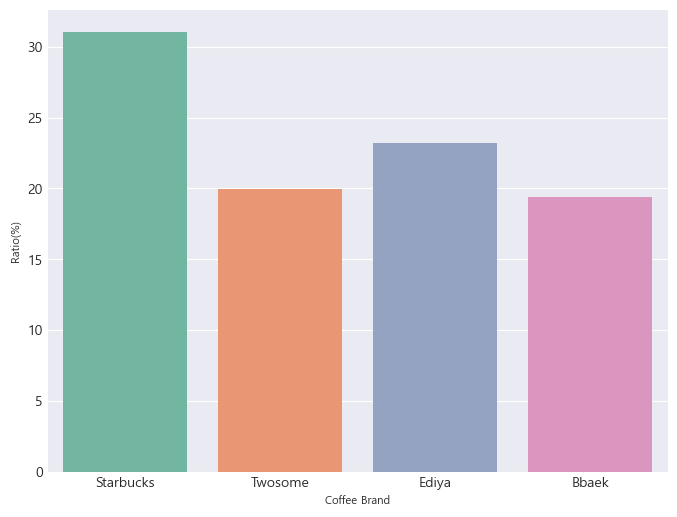

In [31]:
# 주요 3대 커피브랜드 서울 입점 비율을 시각화합니다.
top3_cafe = pd.DataFrame({"Coffee_Brand" : ['Starbucks', 'Twosome', 'Ediya', 'Bbaek'],
                          "Ratio(%)": [31.071, 19.952, 23.218, 19.421]})
#top3_cafe
plt.figure(figsize=(8, 6))
#sns.barplot(data=top3_cafe, x="Coffee_Brand", y="Ratio(%)", palette="Set2")
plt.xlabel('Coffee Brand', fontsize=8)
plt.ylabel('Ratio(%)', fontsize=8)
sns.barplot(x=['Starbucks', 'Twosome', 'Ediya', 'Bbaek'], y=[31.071, 19.952, 23.218, 19.421], palette="Set2")
plt.show()